Note this notebook requires the newest version of `bycycle`, v0.1.3, which can be cloned from GitHub.

In [1]:
from bycycle.features import compute_features
from bycycle.burst import plot_burst_detect_params
from neurodsp.filt import filter_signal
import util
from config import config_dict
import pandas as pd

import h5py
import numpy as np
import os

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib 

matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=15) 

In [2]:
# Make directory for saving figures
if not os.path.exists('figs/s4'):
    os.makedirs('figs/s4')

# Determine signal of interest

In [3]:
# Get info about these recordings
df_stats = pd.read_csv(config_dict['processed_path'] + 'df_shanks_stats.csv', index_col=0)
df_stats = df_stats[df_stats['burst_type']==0].reset_index(drop=True)
df_stats['sh'] = df_stats['sh'].astype(str)

df_plt = df_stats.groupby('rat').last().reset_index()
row = df_plt.loc[0]

# Plot example burst detection

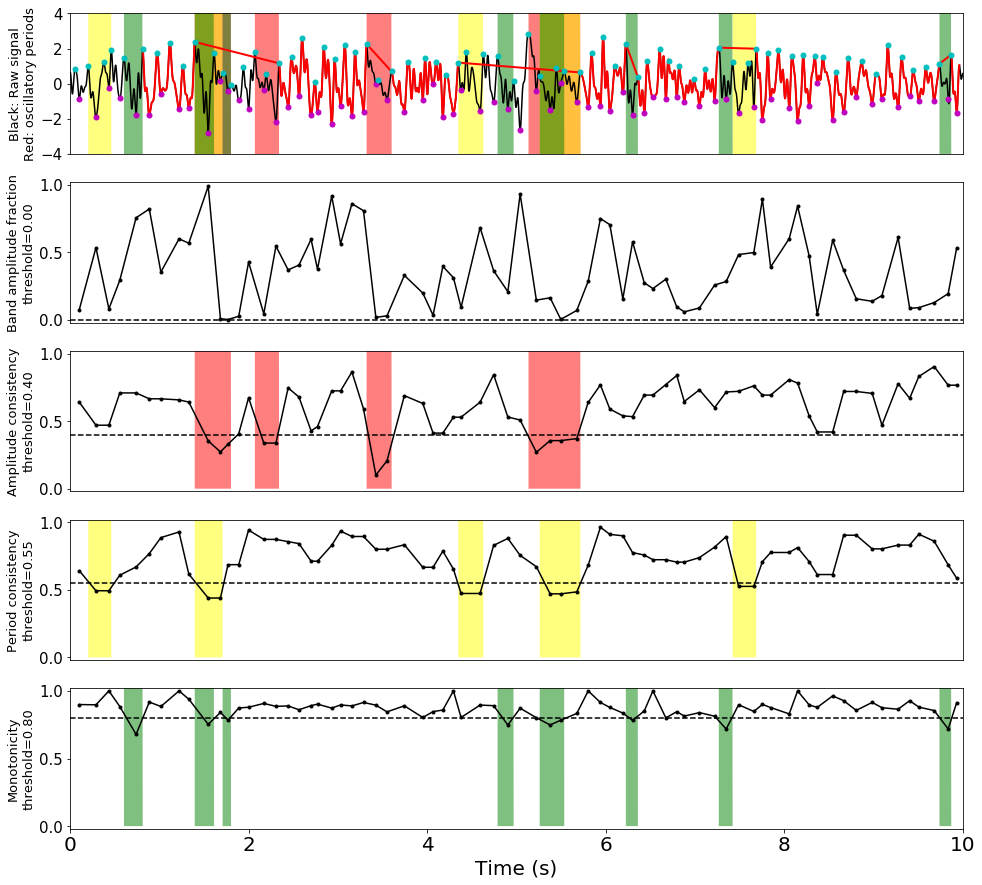

In [19]:
tlims = (30, 40)
figsize = (16, 3)

# Load LFP
lfp_filename = config_dict['mat_path'] + '/' + row['rat'] + '/' + row['sess'] + '/' + row['sh'] + '/' + 'lfp' + str(row['elec']) + '.mat'
f = h5py.File(lfp_filename)
lfp = np.array(f['lfp']).T[0]

# Only consider first 2 minute
lfp = lfp[:int(row['Fs'] * 60 * 2)]

# Broad bandpass filter of LFP
lfp = filter_signal(lfp, row['Fs'], 'lowpass', config_dict['cf_low'], n_seconds=config_dict['N_seconds_low'], 
                    compute_transition_band=False, remove_edge_artifacts=False)
lfp = filter_signal(lfp, row['Fs'], 'highpass', config_dict['cf_high'], n_seconds=config_dict['N_seconds_high'],
                    compute_transition_band=False, remove_edge_artifacts=False)

# Compute shape features
df = compute_features(lfp, row['Fs'], config_dict['f_range'],
                  center_extrema=config_dict['extrema_center'],
                  burst_detection_kwargs=config_dict['burst_kwargs_list'][0])

# Plot burst detection parameters
axs = plot_burst_detect_params(lfp, row['Fs'], df,
                              config_dict['burst_kwargs_list'][0], tlims=tlims,
                              figsize=figsize)
axs[5].set_xticklabels(np.linspace(0, tlims[1]-tlims[0], 6).astype(int), size=20)
for i in range(1,6):
    axs[i].yaxis.label.set_fontsize(13)
# ax.set_ylim((-4, 4))
# ax.set_title('')
# ax.set_ylabel('rat {:s}\nVoltage (normalized)'.format(row['rat']), size=15)
# if i == len(df_plt) - 1:
#     ax.set_xlabel('Time (s)', size=20)
#     ax.set_xticklabels(np.linspace(0, tlims[1] - tlims[0], 6).astype(int), size=20)
# else:
#     ax.set_xlabel('')
#     ax.set_xticks([])
# plt.tight_layout()
plt.savefig('figs/s4/params.png')